# Training Latent Graph Autoencoder

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
import torchvision
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Scale
from torch.utils.data.dataloader import DataLoader
from torch.nn.functional import one_hot
from graph_autoencoder import LatentGraphVAE
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

In [59]:
device = 'cuda:1'

In [60]:
transforms = Compose([
    ToTensor(),
    Resize((320//2, 480//2)),
    ])
dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=1)

In [224]:
def overlap_penalty(layers):
    nlayers = layers.shape[0]
    idxs = torch.combinations(torch.arange(nlayers)).to(device)
    # TODO this 3 assumes that there are 3 channels. Need to make this a variable
    binned = torch.clamp(layers.sum(dim=1)/3, 0)
    overlap = torch.mean((binned[idxs[:,0]] * binned[idxs[:,1]]))
    return overlap

In [65]:
def to_np(tnsr):
    return tnsr.detach().cpu().numpy().transpose((1,2,0))

In [66]:
def l2_penalty(layers):
    return torch.mean(layers**2)

In [67]:
def l1_penalty(layers):
    return torch.mean(torch.abs(layers))

In [68]:
def leaky_clamp(t, a):
    # TODO figure out how to implement this
    pass

In [222]:
def variance(layers):
    midx = torch.argmax(layers.sum(dim=1), dim=0)
    oh = one_hot(midx, num_classes=8).permute((2,0,1))
    return (layers.sum(dim=1) * oh).mean(dim=(1,2)).var()


In [141]:
def build_image(layers):
    midx = torch.argmax(layers.sum(dim=1), dim=0)
    recon = torch.gather(layers, dim=0, index=midx.expand((1,3,-1,-1))).squeeze(0)
    # recon = layers.sum(dim=0)
    return recon

In [243]:
lgvae = LatentGraphVAE(n_channels=3, w=320//2, h=480//2, device=device).to(device)
optim = torch.optim.Adam(params=lgvae.parameters())

optim.zero_grad()
batch_size = 100
n_epochs = 5
i=0
batch_loss = 0
batch_variance = 0
batch_overlap = 0
batch_l1 = 0
batch_total = 0
checkpoint = 1000
niter = 100000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, niter//batch_size)

tmstp = '20221201_1342'

image,_ = next(iter(dataloader))
# print(image.shape)

for epoch in range(n_epochs):
    i=0
    # for image,_ in dataloader:
    for j in range(niter):
        image = image.squeeze(0).to(device)
        nodes = lgvae(image)
        recon = build_image(nodes)
        overlap = overlap_penalty(nodes)
        variance_penalty = variance(nodes)
        recon_loss = torch.mean((recon - image)**2) 
        loss = recon_loss + overlap + variance_penalty
        loss.backward()
        batch_loss += float(recon_loss)/batch_size
        batch_overlap += float(overlap)/batch_size
        batch_total += float(loss)/batch_size
        batch_variance += float(variance_penalty)/batch_size
        
        i+=1
        if i%batch_size==0:
            optim.step()
            optim.zero_grad()
            lr = scheduler.get_last_lr()
            print(f"epoch={epoch:4d} n={i:8d} loss={batch_loss:8.4f} " +
                  f"overlap={batch_overlap:8.4f} variance={batch_variance:8.4f} " + 
                  f"lr={lr} total={batch_total}",
             flush=True)
            batch_loss = 0
            batch_overlap = 0
            batch_variance = 0
            batch_l1 = 0
            batch_total = 0
            # scheduler.step()
        if i%checkpoint==0:
            torch.save(lgvae.state_dict(), f'models/lgvae_{tmstp}.torch')
            n_nodes = nodes.shape[0]
            for node_idx in range(n_nodes):
                midx = torch.argmax(nodes.sum(dim=1), dim=0)
                oh = one_hot(midx, num_classes=n_nodes)
                node = nodes[node_idx]*oh[:,:,node_idx]
                save_image(node, f'outputs/img_{epoch}-{i}-{node_idx}_{tmstp}.png')


epoch=   0 n=     100 loss=  0.1634 overlap=  0.0058 variance=  0.0014 lr=[0.001] total=0.17062331736087777
epoch=   0 n=     200 loss=  0.1632 overlap=  0.0059 variance=  0.0014 lr=[0.001] total=0.17044506967067719
epoch=   0 n=     300 loss=  0.1629 overlap=  0.0060 variance=  0.0027 lr=[0.001] total=0.17150856554508193
epoch=   0 n=     400 loss=  0.1621 overlap=  0.0062 variance=  0.0045 lr=[0.001] total=0.1727534830570224
epoch=   0 n=     500 loss=  0.1602 overlap=  0.0066 variance=  0.0054 lr=[0.001] total=0.17213557660579723
epoch=   0 n=     600 loss=  0.1571 overlap=  0.0073 variance=  0.0060 lr=[0.001] total=0.17040336132049536
epoch=   0 n=     700 loss=  0.1524 overlap=  0.0085 variance=  0.0078 lr=[0.001] total=0.1687132120132442
epoch=   0 n=     800 loss=  0.1452 overlap=  0.0104 variance=  0.0108 lr=[0.001] total=0.1663814783096315
epoch=   0 n=     900 loss=  0.1343 overlap=  0.0137 variance=  0.0152 lr=[0.001] total=0.163290575146675
epoch=   0 n=    1000 loss=  0.11

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


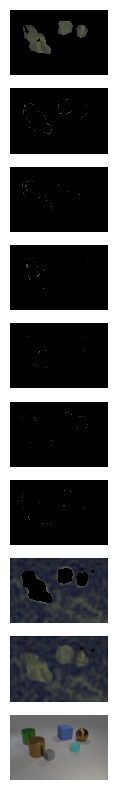

In [244]:
n_nodes = nodes.shape[0]
fig, axs = plt.subplots(n_nodes+2, figsize=(40,10))
nodes = lgvae(image)
for i in range(n_nodes):
    midx = torch.argmax(nodes.sum(dim=1), dim=0)
    oh = one_hot(midx, num_classes=n_nodes)
    node_np = to_np(nodes[i]*oh[:,:,i])
    # node_np = to_np(nodes[i])*8
    axs[i].axis('off')
    axs[i].imshow(node_np, interpolation='none')
axs[n_nodes].axis('off')
axs[n_nodes].imshow(to_np(recon))
axs[n_nodes+1].axis('off')
axs[n_nodes+1].imshow(to_np(image))

In [184]:
nodes[:,2,:4,:4]

tensor([[[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
         [-0.4300, -0.6473, -0.7853, -0.8265],
         [-0.5283, -0.7868, -0.9516, -1.0000],
         [-0.5723, -0.8471, -1.0208, -1.0705]],

        [[-0.2437, -0.3876, -0.4776, -0.5065],
   

## Validation Set testing

In [ ]:
val_dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
iter_val_loader = iter(val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


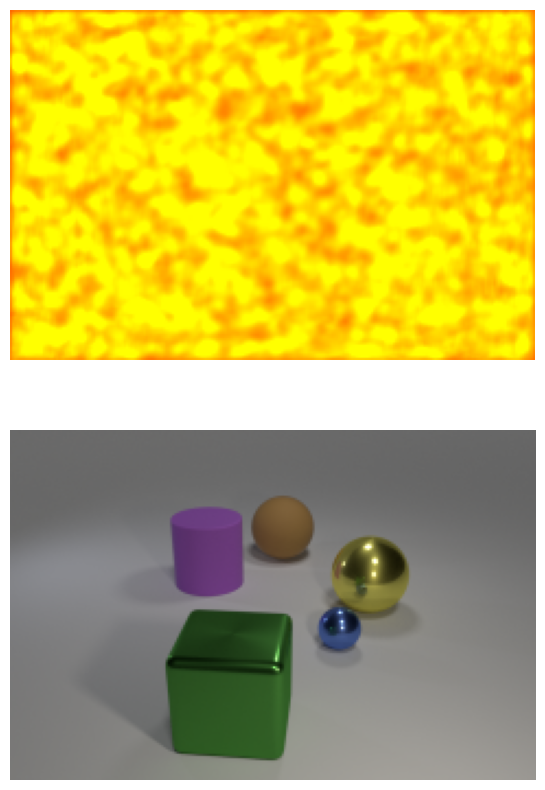

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

with torch.no_grad():
    val_recons = []
    for i in range(10):
        val_image,_ = next(iter_val_loader)
        val_image = val_image.squeeze(0).to(device)
        val_nodes = lgvae(val_image)
        val_recon = build_image(val_nodes)
        val_nprecon = to_np(val_recon)
        val_recons.append(val_recon)
    # print((val_recons[8] - vala_recons[2]).sum())
    axs[0].axis('off')
    axs[0].imshow(val_nprecon*8)
    axs[1].axis('off')
    axs[1].imshow(to_np(val_image))